In [ ]:
!git clone https://github.com/lehoangphuongnhi/Thesis.git

Cloning into 'Thesis'...
remote: Enumerating objects: 237, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 237 (delta 23), reused 21 (delta 8), pack-reused 181
Receiving objects: 100% (237/237), 13.35 MiB | 16.10 MiB/s, done.
Resolving deltas: 100% (119/119), done.


In [ ]:
cd Thesis

/content/Thesis


In [ ]:
!make start-gpu
!pip install wget

make: *** No rule to make target 'start-gpu'.  Stop.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=47c0e4eb03fc01a54ab85c834d52c6a12a72fe41a405e412ca8bceaec282f6dc
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
from Code.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload

%autoreload 2

In [ ]:
#!/usr/bin/env python

import calendar
import os

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder


train = pd.read_csv('/content/train.csv')
store = pd.read_csv('/content/store.csv')

print (train.shape, store.shape)

month_abbrs = calendar.month_abbr[1:]
month_abbrs[8] = 'Sept'


# 1) make integer Year,Month,Day columns instead of Date
# 2) join data from store table
def preprocess(df, stores):
    date = np.array([s.split('-') for s in df['Date']]).astype(int)
    df = df.drop(['Date'], axis=1)
    df['Year'] = date[:, 0]
    df['Month'] = date[:, 1]
    df['Day'] = date[:, 2]
    df = df.join(stores, on='Store', rsuffix='_right')
    df = df.drop(['Store_right'], axis=1)

    print (df.head())

    promo2_start_months = [(s.split(',') if not pd.isnull(s) else []) for s in df['PromoInterval']]

    for month_abbr in month_abbrs:
        df['Promo2Start_' + month_abbr] = np.array([(1 if month_abbr in s else 0) for s in promo2_start_months])
    df = df.drop(['PromoInterval'], axis=1)

    df = df.fillna(0)
    return df


train_prepared_fixed_date = preprocess(train, store)


def get_str_column_names(df):
    str_names = []
    for col in df.columns:
        for x in df[col]:
            if isinstance(x, str):
                str_names.append(col)
                break

    return str_names

train_inds = train_prepared_fixed_date[train_prepared_fixed_date['Year'] == 2014].index
test_inds = train_prepared_fixed_date[train_prepared_fixed_date['Year'] == 2015].index

print ('before iloc' , train_prepared_fixed_date.head())

train2 = train_prepared_fixed_date.iloc[train_inds]
test2 = train_prepared_fixed_date.iloc[test_inds]


str_cat_columns = get_str_column_names(train_prepared_fixed_date)

print(str_cat_columns)


# transform categorical columns with strings using LabelEncoder
def fix_strs(df, cat_names, test_df=None):
    #df[cat_names] = df[df[cat_names] ==0, cat_names].fillna(0)
    # df[df[cat_names] ==0] == '0'
    # test_df[test_df[cat_names] ==0] == '0'

    if test_df is not None:
        test_df[cat_names] = test_df[cat_names].fillna(0)
    for col in cat_names:
        #df[df[col] == 0] = '0'
        enc = LabelEncoder()
        df[col] = enc.fit_transform(df[col].astype(str))
        if test_df is not None:
            #test_df[test_df[col] == 0] = '0'
            test_df[col] = enc.transform(test_df[col].astype(str))
    return df, test_df


print ('before fix_strs' , train2.head())

train2, test2 = fix_strs(train2, str_cat_columns, test2)

print (train2.head())

# all_cat_names = (['Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
#                 'StoreType', 'Assortment', 'Promo2']
#                  + ['Promo2Start_' + month_abbr for month_abbr in month_abbrs])

# if not os.path.exists(config.preprocessed_dataset_path):
#     os.mkdir(config.preprocessed_dataset_path)

# train2.to_csv(os.path.join(config.preprocessed_dataset_path, 'train'), sep='\t', header=False, index=False)
# test2.to_csv(os.path.join(config.preprocessed_dataset_path, 'test'), sep='\t', header=False, index=False)

# with open(os.path.join(config.preprocessed_dataset_path, 'cd'), 'w') as cd:
#     for idx, name in enumerate(train2.columns):
#         cd.write('{}\t{}\n'.format(
#             idx,
#             'Label' if name == 'Sales' else ('Categ\t' + name if name in all_cat_names else 'Num\t' + name))
#         )



/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(1017209, 9) (1115, 10)
   Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
0      1          5   5263        555     1      1            0   
1      2          5   6064        625     1      1            0   
2      3          5   8314        821     1      1            0   
3      4          5  13995       1498     1      1            0   
4      5          5   4822        559     1      1            0   

   SchoolHoliday  Year  Month  Day StoreType Assortment  CompetitionDistance  \
0              1  2015      7   31         a          a                570.0   
1              1  2015      7   31         a          a              14130.0   
2              1  2015      7   31         c          c                620.0   
3              1  2015      7   31         a          a              29910.0   
4              1  2015      7   31         a          a                310.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                       11

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

        Store  DayOfWeek  Sales  Customers  Open  Promo  StateHoliday  \
236380      1          3   2605        327     1      0             0   
236381      2          3   2269        252     1      0             0   
236382      3          3   3804        408     1      0             0   
236383      4          3  10152       1311     1      0             0   
236384      5          3   1830        217     1      0             0   

        SchoolHoliday  Year  Month  ...  Promo2Start_Mar  Promo2Start_Apr  \
236380              1  2014     12  ...                0                1   
236381              1  2014     12  ...                0                1   
236382              1  2014     12  ...                0                0   
236383              1  2014     12  ...                0                0   
236384              1  2014     12  ...                0                0   

        Promo2Start_May  Promo2Start_Jun  Promo2Start_Jul  Promo2Start_Aug  \
236380              

In [ ]:
df2 = train2
df_test2 = test2

In [ ]:
all_cat_names = (['Store', 'DayOfWeek', 'StateHoliday', 'StoreType'])

cat_idxs = [ i for i, f in enumerate(df2.columns) if f in all_cat_names]

cat_dims = [ len(df2[f].value_counts()) + 1 for i, f in enumerate(df2.columns) if f in all_cat_names]
cat_emb_dim = [60, 5,2,2]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(df2.drop(["Sales"], axis = 1), df2['Sales'] , test_size = 100000)

X_test = df_test2.drop(["Sales"], axis = 1).values
y_test = df_test2["Sales"].values.reshape(-1, 1)

In [ ]:
X_train = X_train.values
y_train = y_train.values.reshape(-1, 1)
X_valid = X_valid.values
y_valid = y_valid.values.reshape(-1, 1)

#TabNet

In [ ]:
clf = TabNetRegressor(n_d=28, n_a=28, n_steps=6,
    gamma=1, n_shared=2,
    cat_idxs= cat_idxs ,
    cat_dims= cat_dims,
    cat_emb_dim= [60, 5,2,2],
    lambda_sparse=1.961633378590382e-05, momentum=0.8,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
    scheduler_params=dict(mode="min",
                          patience=4,
                          min_lr=1e-5,
                          factor=0.5,),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau
                     
                     )

max_epoch = 43



/content/Thesis/Code/abstract_model.py:74: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
X_train = X_train.values
y_train = y_train.values.reshape(-1, 1)
X_valid = X_valid.values
y_valid = y_valid.values.reshape(-1, 1)
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmse'],
    max_epochs= max_epoch,
    patience= 15,
    batch_size=4096, vbs=512,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 46670426.36015| train_rmse: 6114.15465| valid_rmse: 6078.01364|  0:00:10s
epoch 1  | loss: 26665313.03588| train_rmse: 3701.55634| valid_rmse: 3666.41793|  0:00:21s
epoch 2  | loss: 4359294.57739| train_rmse: 2501.54298| valid_rmse: 2491.29195|  0:00:32s
epoch 3  | loss: 818471.33656| train_rmse: 4567.60239| valid_rmse: 4556.54567|  0:00:44s
epoch 4  | loss: 494029.55948| train_rmse: 9000.91293| valid_rmse: 8996.75171|  0:00:55s
epoch 5  | loss: 399050.04231| train_rmse: 8795.16522| valid_rmse: 8797.16516|  0:01:06s
epoch 6  | loss: 349659.64185| train_rmse: 6769.02004| valid_rmse: 6777.08352|  0:01:16s
epoch 7  | loss: 333546.05215| train_rmse: 5996.93869| valid_rmse: 6007.94284|  0:01:27s
epoch 8  | loss: 293904.91989| train_rmse: 4901.46581| valid_rmse: 4897.45155|  0:01:38s
epoch 9  | loss: 261813.00084| train_rmse: 5272.87051| valid_rmse: 5279.37479|  0:01:49s
epoch 10 | loss: 257451.87887| train_rmse: 4348.18259| valid_rmse: 4357.38549|  0:02:00s
epoch 11 | loss:

/content/Thesis/Code/callbacks.py:155: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
preds = clf.predict(X_test)

test_mse = mean_squared_error(y_pred= preds, y_true=y_test)
print(f"BEST VALID SCORE FOR Rossmann : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR Rossmann : {np.sqrt(test_mse)}")

In [ ]:
feature_names = ['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'Promo2Start_Jan', 'Promo2Start_Feb',
       'Promo2Start_Mar', 'Promo2Start_Apr', 'Promo2Start_May',
       'Promo2Start_Jun', 'Promo2Start_Jul', 'Promo2Start_Aug',
       'Promo2Start_Sept', 'Promo2Start_Oct', 'Promo2Start_Nov',
       'Promo2Start_Dec']

In [ ]:
feature_importances = pd.DataFrame()
feature_importances["feature"] = feature_names
feature_importances["importance"] = clf._compute_feature_importances(X_train)

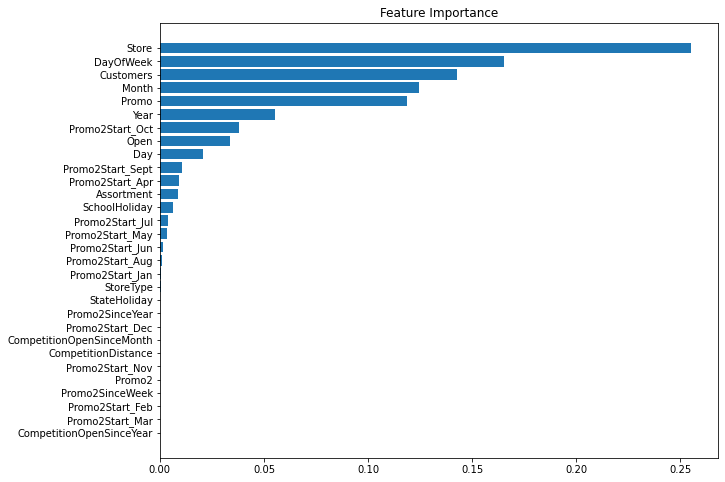

In [ ]:
feature_importances.sort_values(
    by = "importance", 
    ascending = True, 
    inplace = True
)
plt.figure(figsize = (10, 8))
plt.barh(feature_importances["feature"], feature_importances["importance"])
plt.title("Feature Importance")
plt.show()

#XGBoost

In [ ]:
!pip uninstall xgboost

In [ ]:
!pip install xgboost==1.6.1

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [ ]:
for col in all_cat_names:
    train2[col]= train2[col].astype("category")
    test2[col]= test2[col].astype("category")

In [ ]:
PARAMETERS = { 'learning_rate': [v for v in np.geomspace(0.001, 1.0, 10)],'max_depth': np.arange(1, 17),'n_estimators': [int(v) for v in np.geomspace(100, 15000, 10)],}

In [ ]:
model = xgb.XGBRegressor(tree_method="gpu_hist", enable_categorical=True, use_label_encoder=False, max_cat_to_onehot = 2000)
model_gs = GridSearchCV(model,param_grid=PARAMETERS,cv=3,scoring="accuracy")
model_gs.fit(x_train,y_train,early_stopping_rounds=100,eval_set=eval_set,verbose=1, eval_metric='rmse')
print(model_gs.best_params_)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(train2.drop(columns = ['Sales']), train2['Sales'], test_size = 0.1)

In [ ]:
eval_set = [(x_train, y_train), (x_val, y_val)]

In [ ]:
clf = xgb.XGBRegressor(
    tree_method="gpu_hist", enable_categorical=True, use_label_encoder=False, max_cat_to_onehot = 2000, n_estimators = 5000, max_depth = 2, learning_rate=0.001
)

In [ ]:
clf.fit(x_train, y_train,eval_set=eval_set,verbose=1, early_stopping_rounds = 100)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-rmse:6997.01195	validation_1-rmse:7038.14965
[1]	validation_0-rmse:6990.59165	validation_1-rmse:7031.70379
[2]	validation_0-rmse:6984.17808	validation_1-rmse:7025.26469
[3]	validation_0-rmse:6977.77165	validation_1-rmse:7018.83017
[4]	validation_0-rmse:6971.37217	validation_1-rmse:7012.40519
[5]	validation_0-rmse:6964.97957	validation_1-rmse:7005.98455
[6]	validation_0-rmse:6958.59372	validation_1-rmse:6999.57323
[7]	validation_0-rmse:6952.21322	validation_1-rmse:6993.16383
[8]	validation_0-rmse:6945.83974	validation_1-rmse:6986.76151
[9]	validation_0-rmse:6939.47298	validation_1-rmse:6980.36591
[10]	validation_0-rmse:6933.11478	validation_1-rmse:6973.98233
[11]	validation_0-rmse:6926.76190	validation_1-rmse:6967.60066
[12]	validation_0-rmse:6920.41915	validation_1-rmse:6961.23195
[13]	validation_0-rmse:6914.08019	validation_1-rmse:6954.86424
[14]	validation_0-rmse:6907.74783	validation_1-rmse:6948.50316
[15]	validation_0-rmse:6901.40867	validation_1-rmse:6942.12924
[1

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.001, max_bin=256, max_cat_to_onehot=2000,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=5000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [ ]:
preds = clf.predict(test2.drop(columns = ['Sales']))

test_mse = mean_squared_error(y_pred= preds, y_true=test2['Sales'])
print(f"FINAL TEST SCORE FOR Sarcos : {np.sqrt(test_mse)}")

FINAL TEST SCORE FOR Sarcos : 1523.535719703528


In [ ]:
feature_importances = pd.DataFrame()
feature_importances["feature"] = feature_names
feature_importances["importance"] = clf.feature_importances_

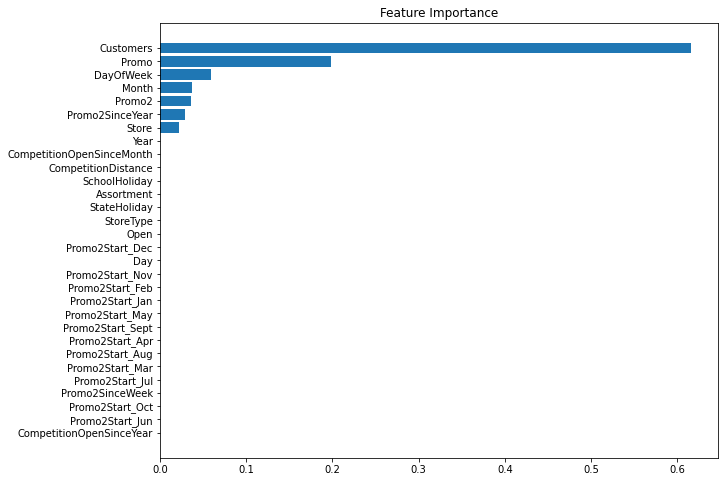

In [ ]:
feature_importances.sort_values(
    by = "importance", 
    ascending = True, 
    inplace = True
)
plt.figure(figsize = (10, 8))
plt.barh(feature_importances["feature"], feature_importances["importance"])
plt.title("Feature Importance")
plt.show()